### Comment
this problem is an irregular time series problem, as there different records within a signle timestamp

In [2]:
import warnings
warnings.filterwarnings("ignore")

#general libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#models
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

#metrics
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix, classification_report

In [3]:
df = pd.read_csv(f'training_dataset.csv').drop(['timestamp'], axis = 1)#, 'labels_average', 'labels', 'special', 'numeric'
#df.drop(['timestamp'], inplace = True, axis = 1) #'longest_word', 'sld'

In [81]:
df = pd.read_csv(f'training_dataset.csv').drop(['timestamp'], axis = 1)

### plotting data

Encode Categorical data

In [85]:
lbl = LabelEncoder()
df['sld'] = lbl.fit_transform(df[['sld']])
df['longest_word'] = lbl.fit_transform(df[['longest_word']])

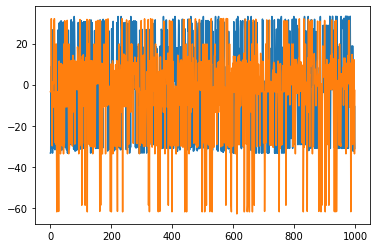

In [5]:
data_shuffle = df.sample(frac=1).reset_index(drop=True)
data_shuffle = data_shuffle.iloc[:1000]


tsne = TSNE(n_components=2, init='random', random_state = 0)
data_plot = tsne.fit_transform(data_shuffle)
plt.plot(data_plot)

The plot shows sequenced data that is not linearly separable, this sequence data I will deal with as a time series

# preprocessing

#### Check Data Balance

1    294353
0    241785
Name: Label, dtype: int64


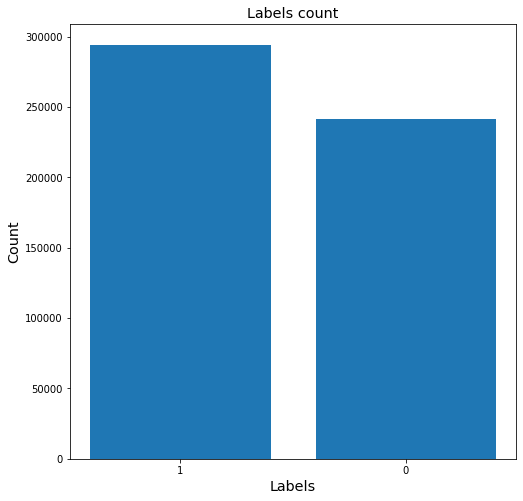

In [5]:
print(df['Label'].value_counts())
fig, ax = plt.subplots(figsize=(8, 8))
plt.bar(['1', '0'], df['Label'].value_counts())
plt.title('Labels count', fontsize = 'x-large')
plt.ylabel('Count', fontsize = 'x-large')
plt.xlabel('Labels', fontsize = 'x-large')
plt.show()

#### check for the existance of Null values


In [6]:
# Make sure that all Na values are disappeared

print(df.isnull().values.any()) #No null values

False


#### Correlations

<AxesSubplot:>

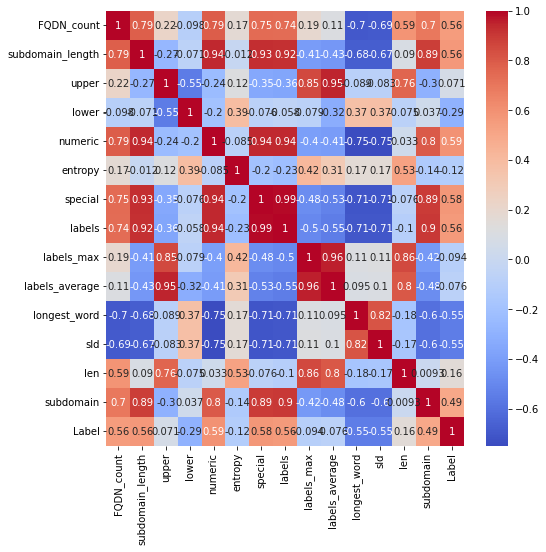

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')

#### Splitting data

In [86]:
y = df.iloc[:,-1]
x = df.drop(['Label'], axis = 1)

In [87]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 0)

#### Implementing Shap

In [18]:
import shap

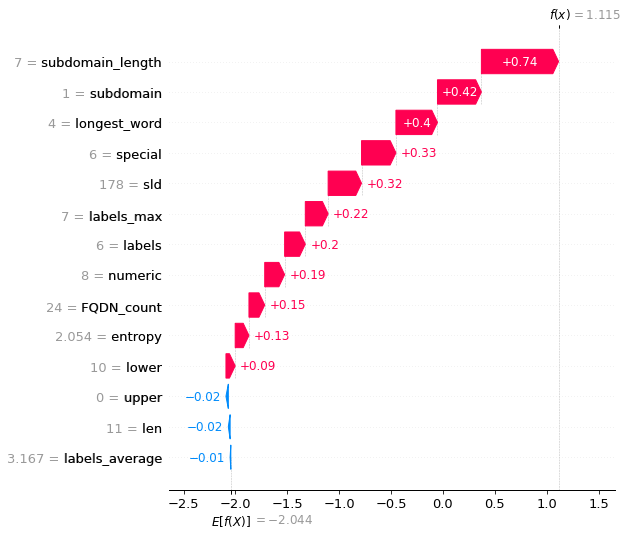

In [11]:
model = CatBoostClassifier(iterations = 1000, learning_rate = 0.05, verbose = False, random_state = 42)
model.fit(xtrain, ytrain, verbose=False,  plot=False)

#implementing shap on the model

explainer = shap.Explainer(model)
shap_values = explainer(xtrain)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display = 16)

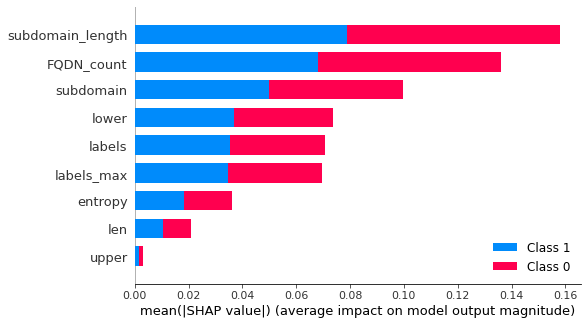

In [31]:
cols = ['subdomain_length', 'upper', 'special', 'labels', 'labels_max', 'FQDN_count', 'subdomain', 'lower', 'entropy']
shap.summary_plot(shap_values, cols, show = False)
plt.savefig('scratch.jpg')

In [23]:
plt.savefig('scratch.png')

<Figure size 432x288 with 0 Axes>

#### Implemeting TSF

In [12]:
# from pyts.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# x = scaler.fit_transform(x)

In [13]:
from pyts.classification import TimeSeriesForest

model = TimeSeriesForest(n_estimators = 2000, criterion = 'gini', min_window_size  = 10, random_state=43)
model.fit(xtrain, ytrain)
model.score(xtest, ytest)

0.8217754069210779

## Running over the whole data exp 1

# Models

### Catboost Classifier

In [88]:
def predict(data, model):
    pred_proba = model.predict_proba(data)
    index = np.unravel_index(np.argmax(pred_proba, axis=None), pred_proba.shape)
    confidence_score = pred_proba[index]
    pred = np.argmax(pred_proba, axis=1) 

    return pred[0], confidence_score

In [89]:
model_cb = CatBoostClassifier(iterations = 2000, learning_rate = 0.05, verbose = False, random_state = 50)
model_cb.fit(xtrain, ytrain, verbose=False)


In [90]:
pred = model_cb.predict(xtest)

In [91]:
print(accuracy_score(ytest, pred))
print(f1_score(ytest, pred))
print(classification_report(ytest, pred))

0.8217567550764104
0.8602582412493847
              precision    recall  f1-score   support

           0       1.00      0.61      0.75     72576
           1       0.75      1.00      0.86     88266

    accuracy                           0.82    160842
   macro avg       0.88      0.80      0.81    160842
weighted avg       0.87      0.82      0.81    160842



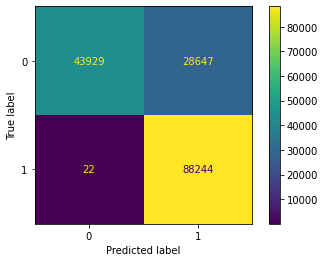

In [92]:
plot_confusion_matrix(model_cb,xtest, ytest)
plt.savefig("catboost_cf.jpg")

### GaussianNB

In [93]:
model_GNB = GaussianNB()
model_GNB.fit(xtrain, ytrain)
ypred = model_GNB.predict(xtest)
print(f'accuracy : {accuracy_score(ytest, ypred)}\n',f'f1_score : {f1_score(ytest, ypred)}')

accuracy : 0.8106651247808409
 f1_score : 0.849116339908141


In [94]:
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred))
print(classification_report(ytest, ypred))

0.8106651247808409
0.849116339908141
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     72576
           1       0.75      0.97      0.85     88266

    accuracy                           0.81    160842
   macro avg       0.85      0.79      0.80    160842
weighted avg       0.84      0.81      0.80    160842



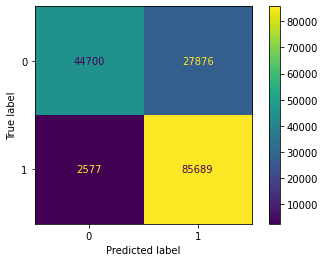

In [95]:
plot_confusion_matrix(model_GNB,xtest, ytest)
plt.savefig("guassianNB_cf.jpg")

### Random Forest

In [96]:
model_rf = RandomForestClassifier(n_estimators = 2000, bootstrap = False, max_depth = None, 
                               max_features = 'auto', random_state = 50)
model_rf.fit(xtrain, ytrain)
ypred = model_rf.predict(xtest)
print(f'accuracy : {accuracy_score(ytest, ypred)}\n',f'f1_score : {f1_score(ytest, ypred)}')

accuracy : 0.8217754069210779
 f1_score : 0.8602735452675498


In [97]:
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred))
print(classification_report(ytest, ypred))

0.8217754069210779
0.8602735452675498
              precision    recall  f1-score   support

           0       1.00      0.61      0.75     72576
           1       0.75      1.00      0.86     88266

    accuracy                           0.82    160842
   macro avg       0.88      0.80      0.81    160842
weighted avg       0.87      0.82      0.81    160842



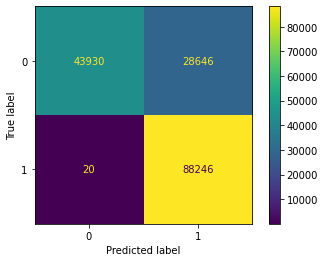

In [98]:
plot_confusion_matrix(model_rf,xtest, ytest)
plt.savefig("RandomForest_cf.jpg")

### running ove the data from the correlation map Exp 2

# Models

In [112]:
X = df.drop(['subdomain_length', 'upper', 'special', 'labels', 'labels_max', 'Label'], axis =1)
y = df.iloc[:,-1]
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Catboost Classifier

In [113]:
def predict(data, model):
    pred_proba = model.predict_proba(data)
    index = np.unravel_index(np.argmax(pred_proba, axis=None), pred_proba.shape)
    confidence_score = pred_proba[index]
    pred = np.argmax(pred_proba, axis=1) 

    return pred[0], confidence_score

In [114]:
model_cb = CatBoostClassifier(iterations = 2000, learning_rate = 0.05, verbose = False, random_state = 50)
model_cb.fit(xtrain, ytrain, verbose=False)


In [115]:
pred = model_cb.predict(xtest)

In [116]:
print(accuracy_score(ytest, pred))
print(f1_score(ytest, pred))
print(classification_report(ytest, pred))

0.8217691896395221
0.8602693520635215
              precision    recall  f1-score   support

           0       1.00      0.61      0.75     72576
           1       0.75      1.00      0.86     88266

    accuracy                           0.82    160842
   macro avg       0.88      0.80      0.81    160842
weighted avg       0.87      0.82      0.81    160842



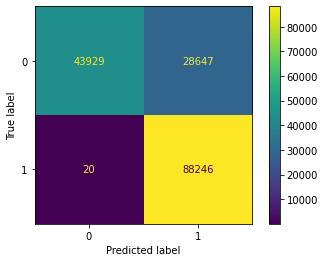

In [117]:
plot_confusion_matrix(model_cb,xtest, ytest)
plt.savefig("catboost_cf.jpg")

### GaussianNB

In [105]:
model_GNB = GaussianNB()
model_GNB.fit(xtrain, ytrain)
ypred = model_GNB.predict(xtest)
print(f'accuracy : {accuracy_score(ytest, ypred)}\n',f'f1_score : {f1_score(ytest, ypred)}')

accuracy : 0.8167145397346465
 f1_score : 0.8532296448237062


In [106]:
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred))
print(classification_report(ytest, ypred))

0.8167145397346465
0.8532296448237062
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     72576
           1       0.76      0.97      0.85     88266

    accuracy                           0.82    160842
   macro avg       0.85      0.80      0.80    160842
weighted avg       0.84      0.82      0.81    160842



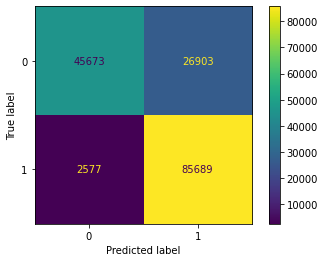

In [107]:
plot_confusion_matrix(model_GNB,xtest, ytest)
plt.savefig("guassianNB_cf.jpg")

### Random Forest

In [118]:
model_rf = RandomForestClassifier(n_estimators = 2000, bootstrap = False, max_depth = None, 
                               max_features = 'auto', random_state = 50)
model_rf.fit(xtrain, ytrain)
ypred = model_rf.predict(xtest)
print(f'accuracy : {accuracy_score(ytest, ypred)}\n',f'f1_score : {f1_score(ytest, ypred)}')

accuracy : 0.8217691896395221
 f1_score : 0.8602693520635215


In [119]:
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred))
print(classification_report(ytest, ypred))

0.8217691896395221
0.8602693520635215
              precision    recall  f1-score   support

           0       1.00      0.61      0.75     72576
           1       0.75      1.00      0.86     88266

    accuracy                           0.82    160842
   macro avg       0.88      0.80      0.81    160842
weighted avg       0.87      0.82      0.81    160842



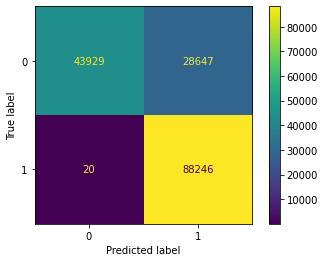

In [120]:
plot_confusion_matrix(model_rf,xtest, ytest)
plt.savefig("RandomForest_cf.jpg")

### The used DataFrame over shap results exp 3

In [8]:
cols = ['FQDN_count', 'subdomain_length', 'upper', 'lower', 'entropy',
        'labels_max', 'len', 'subdomain', 'labels']

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 0)

# Models

### Catboost Classifier

In [12]:
def predict(data, model):
    pred_proba = model.predict_proba(data)
    index = np.unravel_index(np.argmax(pred_proba, axis=None), pred_proba.shape)
    confidence_score = pred_proba[index]
    pred = np.argmax(pred_proba, axis=1) 

    return pred[0], confidence_score

In [77]:
model_cb = CatBoostClassifier(iterations = 2000, learning_rate = 0.05, verbose = False, random_state = 50)
model_cb.fit(xtrain, ytrain, verbose=False)


In [78]:
pred = model_cb.predict(xtest)

In [79]:
print(accuracy_score(ytest, pred))
print(f1_score(ytest, pred))
print(classification_report(ytest, pred))

0.8216261921637383
0.8601415646205445
              precision    recall  f1-score   support

           0       1.00      0.61      0.75     72576
           1       0.75      1.00      0.86     88266

    accuracy                           0.82    160842
   macro avg       0.88      0.80      0.81    160842
weighted avg       0.87      0.82      0.81    160842



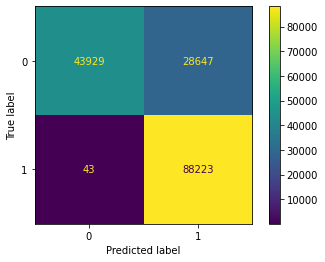

In [80]:
plot_confusion_matrix(model_cb,xtest, ytest)
plt.savefig("catboost_cf.jpg")

### GaussianNB

In [68]:
model_GNB = GaussianNB()
model_GNB.fit(xtrain, ytrain)
ypred = model_GNB.predict(xtest)
print(f'accuracy : {accuracy_score(ytest, ypred)}\n',f'f1_score : {f1_score(ytest, ypred)}')

accuracy : 0.810658907499285
 f1_score : 0.849110637665362


In [70]:
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred))
print(classification_report(ytest, ypred))

0.810658907499285
0.849110637665362
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     72576
           1       0.75      0.97      0.85     88266

    accuracy                           0.81    160842
   macro avg       0.85      0.79      0.80    160842
weighted avg       0.84      0.81      0.80    160842



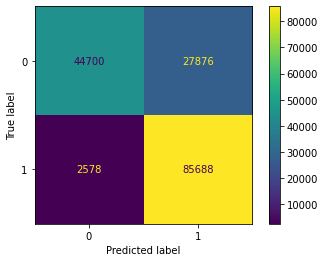

In [73]:
plot_confusion_matrix(model_GNB,xtest, ytest)
plt.savefig("guassianNB_cf.jpg")

### Random Forest

In [74]:
model_rf = RandomForestClassifier(n_estimators = 2000, bootstrap = False, max_depth = None, 
                               max_features = 'auto', random_state = 50)
model_rf.fit(xtrain, ytrain)
ypred = model_rf.predict(xtest)
print(f'accuracy : {accuracy_score(ytest, ypred)}\n',f'f1_score : {f1_score(ytest, ypred)}')

accuracy : 0.821669713134629
 f1_score : 0.8601804594843596


In [75]:
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred))
print(classification_report(ytest, ypred))

0.821669713134629
0.8601804594843596
              precision    recall  f1-score   support

           0       1.00      0.61      0.75     72576
           1       0.75      1.00      0.86     88266

    accuracy                           0.82    160842
   macro avg       0.88      0.80      0.81    160842
weighted avg       0.87      0.82      0.81    160842



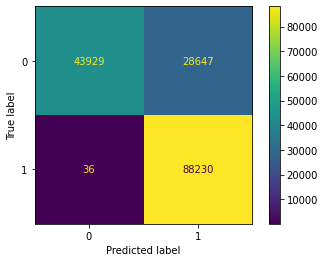

In [76]:
plot_confusion_matrix(model_rf,xtest, ytest)
plt.savefig("RandomForest_cf.jpg")